In [ ]:
pip install gymnasium-robotics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 8.5 MB/s eta 0:00:00



Action Mapping:
0 -> Left
1 -> Down
2 -> Right
3 -> Up

----------------------------------------------
Iteration: 1, Goal state: (3, 3)
Nodes Traversed: 16, Time Taken: 134.4681 ms
Path: [1, 1, 2, 1, 2, 2]
----------------------------------------------
Iteration: 2, Goal state: (2, 2)
Nodes Traversed: 15, Time Taken: 90.3606 ms
Path: [1, 1, 2, 2]
----------------------------------------------
Iteration: 3, Goal state: (1, 3)
Nodes Traversed: 24, Time Taken: 234.1270 ms
Path: [2, 2, 1, 2]
----------------------------------------------
Iteration: 4, Goal state: (3, 1)
Nodes Traversed: 8, Time Taken: 100.6126 ms
Path: [1, 1, 2, 1]
----------------------------------------------
Iteration: 5, Goal state: (2, 3)
Nodes Traversed: 18, Time Taken: 186.2049 ms
Path: [1, 1, 2, 2, 2]
----------------------------------------------


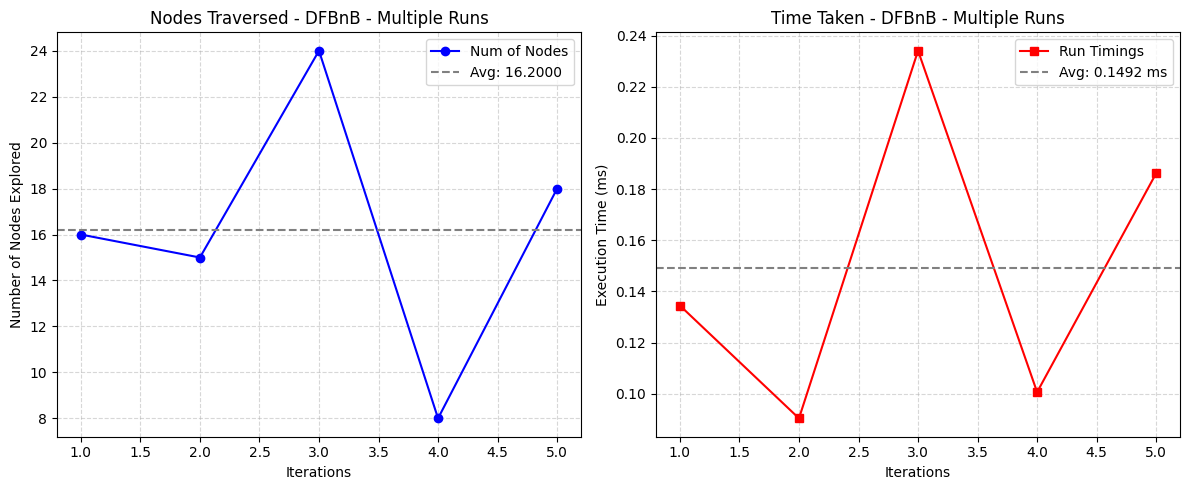

In [ ]:
import gymnasium as gym
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class FL_DFBnB:
    def __init__(self, grid_size=4, target_pos=None):
        self.grid_size = grid_size

        if target_pos:
          self.target_pos = target_pos
        else:
          self.target_pos = (grid_size - 1, grid_size - 1)

        self.desc = self._generate_map()
        self.env = gym.make('FrozenLake-v1', desc=self.desc, is_slippery=False, render_mode='rgb_array')
        self.frames = []
        self.U = float('inf')
        self.best_path = None
        self.d = {}
        self.visited_order = []

    def _generate_map(self):
        """Generate the FrozenLake map."""

        desc = [
            ['S', 'F', 'F', 'F'],
            ['F', 'H', 'F', 'H'],
            ['F', 'F', 'F', 'H'],
            ['H', 'F', 'F', 'F']
        ] if self.grid_size == 4 else [['F'] * self.grid_size for _ in range(self.grid_size)]

        goal_row, goal_col = self.target_pos
        desc[goal_row][goal_col] = 'G'
        return desc

    def _heuristic(self, state):
        """Manhattan distance heuristic."""

        row, col = state // self.grid_size, state % self.grid_size
        target_row, target_col = self.target_pos
        x_cord = abs(row - target_row)
        y_cord = abs(col - target_col)
        return x_cord + y_cord

    def _is_goal(self, state):
        """Check if a state is the goal."""

        return divmod(state, self.grid_size) == self.target_pos

    def _expand(self, state):
        """Get possible state transitions."""

        return [(action, self.env.unwrapped.P[state][action][0][1], 1) for action in range(4)]

    def _dfbnb(self, x, path, current_cost, visited):
        """Depth-First Branch and Bound search."""

        self.visited_order.append(x)
        visited.add(x)

        if self._is_goal(x):
            if current_cost < self.U:
                self.U = current_cost
                self.best_path = path[:]
            return

        for action, y, cost in self._expand(x):
            if current_cost + cost + self._heuristic(y) <= self.U:
                if current_cost + cost < self.d.get(y, float('inf')):
                    self.d[y] = current_cost + cost
                    self._dfbnb(y, path + [action], current_cost + cost, visited.copy())

    def _animate_solution(self, run_idx):
        """Generate an animation of the solution."""

        solution_frames = []
        temp_env = gym.make('FrozenLake-v1', desc=self.desc, is_slippery=False, render_mode='rgb_array')
        state = temp_env.reset(seed=42 + run_idx)[0]
        solution_frames.append(temp_env.render())

        for action in self.best_path:
            state = temp_env.step(action)[0]
            frame = temp_env.render()
            img = Image.fromarray(frame)
            draw = ImageDraw.Draw(img)
            draw.text((10, 10), "Step {}/{}".format(len(solution_frames), len(self.best_path)), fill='black')
            draw.text((10, 30), "Goal: {}".format(self.target_pos), fill='black')
            solution_frames.append(np.array(img))

        solution_frames.extend([temp_env.render()] * 10)
        imageio.mimsave("fl_dfbnb_{}.gif".format(run_idx + 1), solution_frames, duration=3)

    def solve(self, seed, run_idx):
        """Run the DFBnB algorithm and return performance metrics."""

        start_state = self.env.reset(seed=seed)[0]
        self.d = {start_state: 0}
        self.U = 2 * self.grid_size
        self.visited_order = []
        start_time = time.time()
        self._dfbnb(start_state, [], 0, set())
        time_taken_ms = (time.time() - start_time) * 1000

        if self.best_path:
            self._animate_solution(run_idx)

        return len(self.visited_order), self.best_path, time_taken_ms


def main():
    runs = 5
    goal_positions = [(3, 3), (2, 2), (1, 3), (3, 1), (2, 3)]
    nodes_traversed, times_taken = [], []

    print("\nAction Mapping:")
    print("0 -> Left\n1 -> Down\n2 -> Right\n3 -> Up\n")
    print("----------------------------------------------")

    for i in range(runs):
        solver = FL_DFBnB(grid_size=4, target_pos=goal_positions[i])
        num_nodes, solution, time_taken = solver.solve(seed=42 + i, run_idx=i)
        nodes_traversed.append(num_nodes)
        times_taken.append(time_taken)

        print("Iteration: {0}, Goal state: {1}".format(i + 1, solver.target_pos))
        print("Nodes Traversed: {0}, Time Taken: {1:.4f} ms".format(num_nodes, time_taken * 1000))
        print("Path: {0}".format(solution))
        print("----------------------------------------------")

    visualize_results(runs, nodes_traversed, times_taken)

def visualize_results(iterations, nodes, times):
    """Plot performance metrics with averages, save combined and individual plots."""

    def create_plot(x, y, avg, ylabel, label_leg, title, color, marker, filename, y_suffix=""):
        plt.figure()
        plt.plot(x, y, marker=marker, linestyle='-', color=color, label=label_leg)
        plt.axhline(y=avg, color='gray', linestyle='--', label="Avg: {:.4f}{}".format(avg, y_suffix))
        plt.xlabel("Iterations")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.close()

    avg_nodes = sum(nodes) / len(nodes)
    avg_time_ms = sum(times) / len(times)
    x_vals = list(range(1, iterations + 1))

    # --- Combined Subplots ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Subplot: Nodes Explored
    axs[0].plot(x_vals, nodes, marker='o', linestyle='-', color='blue', label="Num of Nodes")
    axs[0].axhline(y=avg_nodes, color='gray', linestyle='--', label="Avg: {:.4f}".format(avg_nodes))
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Number of Nodes Explored")
    axs[0].set_title("Nodes Traversed - DFBnB - Multiple Runs")
    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].legend()

    # Subplot: Execution Time
    axs[1].plot(x_vals, times, marker='s', linestyle='-', color='red', label="Run Timings")
    axs[1].axhline(y=avg_time_ms, color='gray', linestyle='--', label="Avg: {:.4f} ms".format(avg_time_ms))
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Execution Time (ms)")
    axs[1].set_title("Time Taken - DFBnB - Multiple Runs")
    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig("dfbnb_combined.png", dpi=300)
    plt.show()

    # --- Save individual plots ---
    create_plot(
        x_vals, nodes, avg_nodes,
        ylabel="Number of Nodes Explored",
        label_leg="Num of Nodes",
        title="Nodes Traversed - DFBnB - Multiple Runs",
        color='blue', marker='o',
        filename="dfbnb_nodes_trav.png"
    )

    create_plot(
        x_vals, times, avg_time_ms,
        ylabel="Execution Time (ms)",
        label_leg="Run Timings",
        title="Time Taken - DFBnB - Multiple Runs",
        color='red', marker='s',
        filename="dfbnb_timeplot.png",
        y_suffix=" ms"
    )


if __name__ == "__main__":
    main()